In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import vice

In [2]:
# import surp.analysis.apogee_analysis as aah
# from surp.analysis.vice_model import vice_model
# from surp import yields
# from surp import analysis
# import arya # plot style



In [3]:
# yields.py file

import vice
import numpy as np
from vice.yields.agb import interpolator
from scipy.integrate import quad
from vice.yields import ccsne, sneia, agb



# Constants
Z_Sun = 0.014

Y_C_0 = 0.0052
ZETA_0 = 0.06
XI_0 = 0 # 2.6

y_n_flat = 7.2e-4
Z_III = Z_Sun * 10**-4


Y_AGB = {
        "cristallo11": 4.2e-4,
        "karakas10": 6.4e-4,
        "ventura13": 2.2e-4,
        "karakas16": 5.1e-4,
        "pignatari16": 3.5e-3,
        "A": 5e-4,
}

ZETA_AGB = {
        "cristallo11": -0.0175,
        "karakas10": -0.059,
        "ventura13": -0.021,
        "karakas16": -0.029,
        "pignatari16": 0.1,
}


# default settings


def set_yields(eta=1, zeta=None, fe_ia_factor=None,
               agb_model="cristallo11", oob=False, f_agb=0.2,
               alpha_n=0, 
               gamma=1,
               mass_factor=1,
               zeta_agb=-0.03,
               xi=0,
               **kwargs
              ):
    """
    Parameters
    ----------

    eta
    
    """
    set_defaults()

    set_fe(fe_ia_factor)


    alpha_agb = calc_alpha(agb_model, oob, f_agb)
    y_cc = calc_ycc(agb_model, alpha_agb)
    if zeta is None:
        zeta = calc_zeta(agb_model, alpha_agb, zeta_agb)
        zeta = zeta - 0.016/2.6 * xi

    # correct ...
    alpha_agb *= eta
    y_cc *= eta
    zeta *= eta

    set_agb(agb_model, alpha_agb, mass_factor, zeta_agb=zeta_agb, **kwargs)

    set_n(eta, alpha_n)
    
    vice.yields.ccsne.settings["c"] = C_CC_model(zeta=zeta, y0=y_cc,
            xi=xi)


    set_eta(eta)

    set_isotopic()

    print_yields()




def set_isotopic():
    vice.yields.sneia.settings["au"] = 0
    vice.yields.ccsne.settings["au"] = 0
    vice.yields.agb.settings["au"] = lambda m, z: 0
    vice.yields.sneia.settings["ag"] = 0
    vice.yields.ccsne.settings["ag"] = 0
    vice.yields.agb.settings["ag"] = lambda m, z: 0

class LinAGB:
    def __init__(self, zeta, y0):
        self.zeta = zeta
        self.y0 = y0

    def __call__(self, M, Z):
        return M*self.y0 + M*Z/Z_Sun * self.zeta

    def __str__(self):
        return f"{self.y0:0.2e} M + {self.zeta:0.2e} M Z/Z0"




class C_CC_model:
    def __init__(self, zeta=0.1, y0=0.004, pop_iii=0.2, Z_iii=Z_III, xi=XI_0):
        # defaults
        # zeta = 0.70
        # y0 = 0.004
        # Z_iii = 10**-5.5
        # pop_iii = 0.005
        self.y0 = y0
        self.zeta = zeta
        self.pop_iii = pop_iii
        self.Z_iii = Z_iii
        self.xi = xi

    def __call__(self, Z):
        return (self.y0 
            + self.zeta * (Z - Z_Sun) 
            + self.xi * (Z - Z_Sun)**2
            + self.y0 * self.pop_iii*2/(1 + Z/self.Z_iii))

    def __str__(self):
        if self.xi == 0:
            return f"{self.y0:0.2e} + {self.zeta:0.2e} (Z - Z0)"
        else:
            return f"{self.y0:0.2e} + {self.zeta:0.2e} (Z-Z0) + {self.xi:0.1e}(Z-Z0)^2"



class ZeroAGB:
    def __init__(self):
        pass

    def __call__(self, *args, **kwargs):
        return 0

    def __str__(self):
        return "0"

    def __repr__(self):
        return "0"

def set_defaults():
    sneia.settings["c"] = 0

    ccsne.settings["o"] = 0.015
    sneia.settings["o"] = 0
    agb.settings["o"] = ZeroAGB()

    ccsne.settings["fe"] = 0.0012
    sneia.settings["fe"] = 0.0017
    agb.settings["fe"] = ZeroAGB()
    # sneia.settings["fe"] *= 10**0.1 # correction for mdf, used in

    ccsne.settings["sr"] = 3.5e-8
    sneia.settings["sr"] = 0

    ccsne.settings["n"] = 3.6e-4
    sneia.settings["n"] = 0


    ccsne.settings["mg"] = 0.00185
    sneia.settings["mg"] = 0
    agb.settings["mg"] = ZeroAGB()





def set_agb_elem(elem, study, factor, **kwargs):
    if study == "A":
        study = "cristallo11"

    if elem == "fe" and agb_model == "ventura13":
        study = "cristallo11"

    agb.settings[elem] = interpolator(elem, study, prefactor=factor, **kwargs)



def set_agb(study="cristallo11", factor=1, mass_factor=1, no_negative=False, **kwargs):
    for elem in ["c"]:
        set_agb_elem(elem, study, factor, mass_factor=mass_factor, no_negative=no_negative)

    if study == "A":
        agb.settings["c"] = a_agb(ym_agb=factor * Y_AGB["A"], **kwargs)


def set_fe(fe_ia_factor):
    if fe_ia_factor:
        fe_total = vice.yields.sneia.settings["fe"] + vice.yields.ccsne.settings["fe"]
        fe_ia = vice.yields.sneia.settings["fe"] * fe_ia_factor
        fe_cc = fe_total - fe_ia
        vice.yields.ccsne.settings["fe"] = fe_cc
        vice.yields.sneia.settings["fe"] = fe_ia



def set_eta(eta=1):
    if eta==1:
        return

    for elem in ["o", "fe", "mg", "sr", "n"]:
        y = ccsne.settings[elem] 
        if isinstance(y, float):
            ccsne.settings[elem] *= eta

        y = sneia.settings[elem] 
        if isinstance(y, float):
            sneia.settings[elem] *= eta


def set_n(eta, alpha_n):
    y_cc_n = eta*y_n_flat * (1-alpha_n)
    y_n_0 = eta*y_n_flat * alpha_n
    vice.yields.agb.settings["n"] = LinAGB(zeta=9e-4, y0=y_n_0)
    vice.yields.ccsne.settings["n"] = y_cc_n





def calc_alpha(agb_model="cristallo11" , oob=False, f_agb=0.2):
    y_agb = Y_AGB[agb_model]
    if oob:
        alpha = 1
    else:
        alpha = f_agb * Y_C_0 /y_agb
    return alpha


def calc_ycc(agb_model, alpha_agb):
    y_agb = Y_AGB[agb_model]

    y_cc = Y_C_0 - alpha_agb * y_agb 
    return y_cc


def calc_zeta(agb_model, alpha_agb, zeta_agb):
    if agb_model != "A":
        zeta_agb = alpha_agb * ZETA_AGB[agb_model]

    return ZETA_0 - zeta_agb


def a_agb(m_low=1.3, m_mid=None, m_high=4, yl_agb=0, ym_agb=5e-4, yh_agb=0,
        zeta_agb=-0.03, mz_agb=0):
    """
    An analytic version of AGB yields.

    Parameters
    ----------
    m_low: the beginning of the cubic spline.
    m_mid: the peak mass. If None, defaults to the average of m_low and m_high
    m_high: the end of the cubic spline. 
    yl_agb: the yield at m_low
    ym_agb: the total yield
    yh_agb: the yield at m_high 
    zeta_agb: the metallicity dependent part of the yield at ym_agb
    mz_agb: mass-metallicity coupling constant
    """
    if m_mid is None:
        m_mid = (m_low + m_high)/2

    def y_spline(m):
        return spline(m, [m_low, m_mid, m_high], [yl_agb, ym_agb, yh_agb])


    imf_norm = quad(lambda m: m*vice.imf.kroupa(m), 0.08, 100)[0]

    def f(m):
        return m * vice.imf.kroupa(m)/imf_norm * y_spline(m)

    A_agb = 1 / quad(f, m_low, m_high)[0]

    def inner(m, z):
        if z > 0:
            m_h = np.log10(z/Z_Sun)
        elif z == 0:
            m_h = -8
        else:
            print("warning, negative z, z=", z)
        return A_agb * y_spline(m + mz_agb*m_h) * (ym_agb + zeta_agb * (z - Z_Sun) )
    return inner



def sspline(x):
    if x < 0 or 1 < x:
        return 0
    return 3*x**2 - 2*x**3

def pspline(x, x0, y0):
    m = y0[1] - y0[0]
    if x0[0] <= x <= x0[1]:
        return y0[0] + m*sspline( (x-x0[0])/(x0[1] - x0[0]) )
    else:
        return 0


def spline(x, xs, ys):
    s = 0

    if x < xs[0]:
        return ys[0]
    if x > xs[-1]:
        return ys[-1]

    for i in range(len(xs) - 1):
        x0 = (xs[i], xs[i+1])
        y0 = (ys[i], ys[i+1])
        s += pspline(x, x0, y0)
        
    return s


def print_yields():
    # print header
    print("Yield settings")
    print_row("X", "CC", "agb", "SN Ia")

    # print values
    for elem in ["c", "n", "o", "mg", "fe"]:
        print_row(elem, 
                ccsne.settings[elem],
                agb.settings[elem],
                sneia.settings[elem])

    print()
    print()



def print_row(*args):
    for i in range(len(args)):
        arg = args[i]
        if isinstance(arg, float):
            s = "%0.2e" % arg
        else:
            s = str(arg)

        if i==0:
            print(f"{s:8}", end="")
        elif i==(len(args)-1):
            print(f"{s}", end="")
        else:
            print(f"{s:30}", end="")
    print()


def nugrid_c(factor=1, mass_factor=1):
    nugrid_c = pd.read_csv("../data/nugrid_c.csv")
    nugrid_c["y"] = nugrid_c["yC"] - nugrid_c["ZC0"]
    nugrid_c = nugrid_c[nugrid_c.m <= 8].copy()

    c_table = nugrid_c.pivot(index="m", columns="Z", values="y")
    M = np.array(c_table.index)
    Z = np.array(c_table.columns.array)

    y_ng = vice.toolkit.interpolation.interp_scheme_2d(mass_factor*M, Z, factor*np.array(c_table))

    return y_ng


In [4]:
# GCE math.py

import numpy as np
import vice


Z_SUN = 0.014

def Z_to_MH(Z):
    if type(Z) in (list, tuple):
        x = np.array(Z)
    else:
        x = Z
    return np.log10(x/Z_SUN)

def MH_to_Z(M_H):
    if type(M_H) in (list, tuple):
        x = np.array(M_H)
    else:
        x = M_H
    return Z_SUN * 10**x


def log_to_bracket(ratio, elem, elem2="H"):
    """Calculates [A/B] from log A/B
    Parameters
    ----------
    ratio : float or list-like
        The input value of log A/B
    elem : str
        The string of element A
    elem2 : str
        The string of element B, default H
        
    Returns
    -------
    The value of [A/B]
    """

    if isinstance(ratio, list):
        r = np.array(ratio)
    else:
        r = ratio
        

    if elem2 == "H":
        return r - np.log10(vice.solar_z(elem)) + np.log10(mm_of_elements[elem])
    else:
        return r - np.log10(vice.solar_z(elem)/vice.solar_z(elem2)) + np.log10(mm_of_elements[elem]/mm_of_elements[elem2])


def bracket_to_abundance(data, ele, ele2="h"):
    if ele2 == "h":
        return 10**data * vice.solar_z(ele)
    else:
        return 10**data * vice.solar_z(ele) / vice.solar_z(ele2)

def abundance_to_bracket(data, ele, ele2="h"):
    if ele2.lower() == "h":
        return np.log10(data/vice.solar_z(ele))
    else:
        return np.log10(data) - np.log10(vice.solar_z(ele) / vice.solar_z(ele2))


def cpn(c1, n1):
    if type(c1) in (list, tuple):
        c = np.array(c1)
    else:
        c = c1
    if type(n1) in (list, tuple):
        n = np.array(n1)
    else:
        n = n1

    return np.log10( (bracket_to_abundance(c, "c") + bracket_to_abundance(n, "n")) / (vice.solar_z("c") + vice.solar_z("n")) )


def cmn(c1, n1):
    if type(c1) in (list, tuple):
        c = np.array(c1)
    else:
        c = c1
    if type(n1) in (list, tuple):
        n = np.array(n1)
    else:
        n = n1
    return np.log10( (bracket_to_abundance(c, "c") - bracket_to_abundance(n, "n")) / (vice.solar_z("c") - vice.solar_z("n")) )


def bracket(df, ele, ele2="H"):
    """
    Helper function for subgiants()
    creates the abundance ratio [A/B]
    from the  APOGEE dataframe
    """
    if ele2 == "H":
        if ele == "FE":
            return df["FE_H"]
        else:
            return df["%s_FE" % ele] + df["FE_H"]
    else:
        if ele2 == "FE":
            return df["%s_FE" % ele]
        else:
            return df["%s_FE" % ele] - df["%s_FE" % ele2]


def mg_fe_cutoff(fe_h):
    """
    The cutoff between the high and low alpha seqeunces

    Parameters
    ----------
    fe_h: float or np.array
        The [Fe/H] values to evaluate the boandry at

    Returns
    -------
    mg_fe: float or np.array
        The [Mg/Fe] above which the high alpha sequence is defined
    """
    return 0.12 - (fe_h < 0) * 0.13 * fe_h


def is_high_alpha(mg_fe, fe_h):
    return mg_fe > mg_fe_cutoff(fe_h)

mm_of_elements = {'h': 1.00794, 'he': 4.002602, 'li': 6.941, 'be': 9.012182,
                  'b': 10.811, 'c': 12.0107, 'n': 14.0067, 'o': 15.9994, 
                  'f': 18.9984032, 'ne': 20.1797, 'na': 22.98976928, 'mg': 24.305, 
                  'al': 26.9815386, 'si': 28.0855, 'p': 30.973762, 's': 32.065, 
                  'cl': 35.453, 'ar': 39.948, 'k': 39.0983, 'ca': 40.078,
                  'sc': 44.955912, 'ti': 47.867, 'v': 50.9415, 'cr': 51.9961, 
                  'mn': 54.938045, 'fe': 55.845, 'co': 58.933195, 'ni': 58.6934, 
                  'cu': 63.546, 'zn': 65.409, 'ga': 69.723, 'ge': 72.64,
                  'as': 74.9216, 'se': 78.96, 'br': 79.904, 'kr': 83.798, 
                  'rb': 85.4678, 'sr': 87.62, 'y': 88.90585, 'zr': 91.224, 
                  'nb': 92.90638, 'mo': 95.94, 'tc': 98.9063, 'ru': 101.07, 
                  'rh': 102.9055, 'pd': 106.42, 'ag': 107.8682, 'cd': 112.411, 
                  'in': 114.818, 'sn': 118.71, 'sb': 121.760, 'te': 127.6,
                  'i': 126.90447, 'xe': 131.293, 'cs': 132.9054519, 'ba': 137.327, 
                  'la': 138.90547, 'ce': 140.116, 'pr': 140.90465, 'nd': 144.242,
                  'pm': 146.9151, 'sm': 150.36, 'eu': 151.964, 'gd': 157.25,
                  'tb': 158.92535, 'dy': 162.5, 'ho': 164.93032, 'er': 167.259,
                  'tm': 168.93421, 'yb': 173.04, 'lu': 174.967, 'hf': 178.49,
                  'ta': 180.9479, 'w': 183.84, 're': 186.207, 'os': 190.23,
                  'ir': 192.217, 'pt': 195.084, 'au': 196.966569, 'hg': 200.59,
                  'tl': 204.3833, 'pb': 207.2, 'bi': 208.9804, 'po': 208.9824,
                  'at': 209.9871, 'rn': 222.0176, 'fr': 223.0197, 'ra': 226.0254, 
                  'ac': 227.0278, 'th': 232.03806, 'pa': 231.03588, 'u': 238.02891,
                  'np': 237.0482, 'pu': 244.0642, 'am': 243.0614, 'cm': 247.0703,
                  'bk': 247.0703, 'cf': 251.0796, 'es': 252.0829, 'fm': 257.0951,
                  'md': 258.0951, 'no': 259.1009, 'lr': 262, 'rf': 267,
                  'db': 268, 'sg': 271, 'bh': 270, 'hs': 269, 'mt': 278,
                  'ds': 281, 'rg': 281, 'cn': 285, 'nh': 284, 
                  'fl': 289, 'mc': 289, 'lv': 292, 'ts': 294, 
                  'og': 294,
                  '': 0}


In [5]:
all_abundances = pd.read_csv("all_data.csv")

# subgiants = aah.subgiants
# filt = ~np.isnan(subgiants["C_MG"])
# filt &= ~np.isnan(subgiants["MG_H"])
# filt &= subgiants["high_alpha"]
# subgiants = subgiants[filt]

# fiducial = vice_model("../out/C11_f0.2_rand_walk.json")

Parameters from james et al. dwarf paper:

- $\tau_{\rm in} = 1.01 \pm 0.13\,$Gyr
- $\eta = 8.8 \pm 0.9$
- $\tau_{\star} = 16.1 \pm 1.3\,$Gyr
- $\tau_{\rm end} = 5.4\pm0.3\,$Gyr
- $y_{\rm Fe}^{\rm cc} = 7.8\pm0.4 \times 10^{-4}$
- $y_{\rm Fe}^{\rm Ia} = 1.2\pm0.1\times 10^{-3}$

As we assume different Fe yields, we adjust $\eta$ accordingly. Our total Fe yields are 2.9e-3, so
$$
\frac{\eta}{
\eta_{\rm J+22}
} = 
\frac{2.9\times 10^{-3}}{
2 \pm 0.4 \times 10^{-3}}
= 1.5 \pm 0.3
$$
in agrement with the difference in alpha-abundance assumptions. 
$$
\eta = 13.2 \pm 1.3
$$

In [6]:
def sfh(tau=3):
    return lambda t: np.exp(-t/tau)

def sz_model(eta=13.2, tau_star=16.1, t_end=5.4, tau_sfh=1, dt=0.005):
    sz = vice.singlezone(elements=["o", "mg", "c", "fe"], dt=dt, eta=eta, func=sfh(tau=tau_sfh), mode="ifr", tau_star=tau_star, Mg0=0)
    out = sz.run(np.arange(0, t_end, dt), capture=True, overwrite=True)
    return out

In [21]:
set_yields(oob=False)
y_cc_c = vice.yields.ccsne.settings["c"]
yo = vice.yields.ccsne.settings["o"]

Yield settings
X       CC                            agb                           SN Ia
c       4.16e-03 + 1.03e-01 (Z - Z0)  2.48 × cristallo11            0
n       7.20e-04                      0.00e+00 M + 9.00e-04 M Z/Z0  0
o       1.50e-02                      0                             0
mg      1.85e-03                      0                             0
fe      1.20e-03                      0                             1.70e-03




In [22]:
# grab total yield trend

MoverH = np.linspace(-4, 1)
Z = MH_to_Z(MoverH)

y_total = []
for mh in MoverH:
    yc, times = vice.single_stellar_population("c", Z=0.014*10**mh)
    y_total.append(yc[-1]/1e6)
    
    
y_total = np.array(y_total)

# plt.plot(MoverH, analysis.abundance_to_bracket(y_total/yo, "c", "o"), label="Total")
# plt.plot(MoverH, analysis.abundance_to_bracket((y_total-y_cc_c(Z))/yo, "c", "o"), label="AGB")
# plt.plot(MoverH, analysis.abundance_to_bracket(y_cc_c(Z)/yo, "c", "o"), label="CCSNe")


# df = aah.subgiants[~aah.subgiants.high_alpha]
# arya.medianplot(df, x="MG_H", y="C_MG", binsize=200, stat="median", errorbar=None, aes="line", label="data")

# plt.legend()
# plt.xlabel("[M/H]")
# plt.ylabel("[C/O]")
# plt.ylim(-0.75, 0.25)
# plt.xlim(-4, 1)

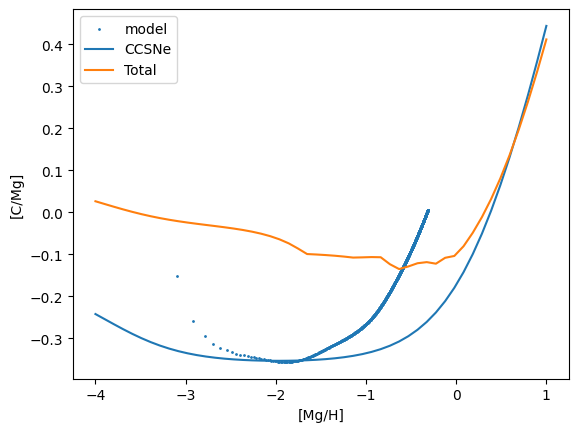

In [23]:



plt.scatter(model.history["[o/h]"], model.history["[c/o]"], label="model", s=1)


plt.plot(MoverH, abundance_to_bracket(y_cc_c(Z)/yo, "c", "o"), label="CCSNe")
plt.plot(MoverH, abundance_to_bracket(y_total/yo, "c", "o"), label="Total")



plt.xlabel("[Mg/H]")
plt.ylabel("[C/Mg]")

plt.legend()

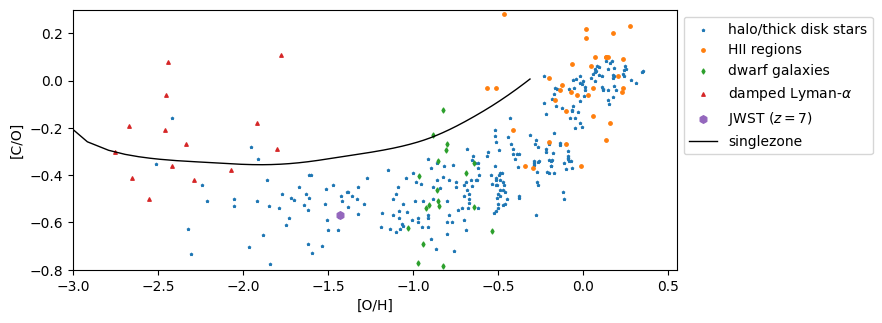

In [24]:
plt.figure(figsize=(7, 10/3))

for i in [2,0,1,3]:
    label = ["HII regions", "dwarf galaxies", "halo/thick disk stars", "damped Lyman-$\\alpha$"][i]
    val = ["RL", "dwarf", "star", "DLA"][i]
    df = all_abundances[all_abundances.type == val]
    plt.scatter(df["[o/h]"], df["[c/o]"], label=label,
               marker=["o", "d", "*", "^"][i], s=[6, 6, 3, 6][i], 
               )
    
    



# ha = subgiants["high_alpha"]
# df = subgiants[ha]
# arya.binnedplot(df, x="O_H", y="C_O", errorbar=None, binrange=(-0.3, 0.2), bins=10, stat="median", 
#                 edgecolor=arya.style.COLORS[2], facecolor='none', marker="o", s=30,
#             zorder=-1, label="subgiants, high $\\alpha$")

plt.plot()

plt.ylim(-0.8, 0.3)
plt.xlim(-3, 0.55)

plt.xlabel(r"[$\alpha$/H]")
plt.ylabel(r"[C/$\alpha$]")

plt.scatter([-1.43], [-0.57], marker="h", s=30, label="JWST ($z=7$)")


# fiducial.plot_gas("[o/h]", "[c/o]", label="Model ($t=13.2$ Gyr)", plot_data=False, zorder=3, lw=1.5, color=arya.style.COLORS[5])

# fiducial.plot_annulus_at_t("[o/h]", "[c/o]", t=2, label="Model ($t=2$ Gyr)", zorder=3, lw=2, color=arya.style.COLORS[4])


plt.plot(model.history["[o/h]"], model.history["[c/o]"], label="singlezone", color="k", lw=1, zorder=4)



# leg = arya.Legend(loc=-1).mpl_leg
#leg.legend_handles[-1].set_sizes([4])
#leg.legend_handles[-1].set_alpha(1)

plt.xlabel(r"[O/H]")
plt.ylabel(r"[C/O]")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1,1), loc="upper left")

# Weird model

In [15]:
set_yields(mass_factor=1.5, no_negative=False, f_agb=0.2, xi=0)
y_cc_c = vice.yields.ccsne.settings["c"]
yo = vice.yields.ccsne.settings["o"]

Yield settings
X       CC                            agb                           SN Ia
c       4.16e-03 + 1.03e-01 (Z - Z0)  2.48 × cristallo11            0
n       7.20e-04                      0.00e+00 M + 9.00e-04 M Z/Z0  0
o       1.50e-02                      0                             0
mg      1.85e-03                      0                             0
fe      1.20e-03                      0                             1.70e-03




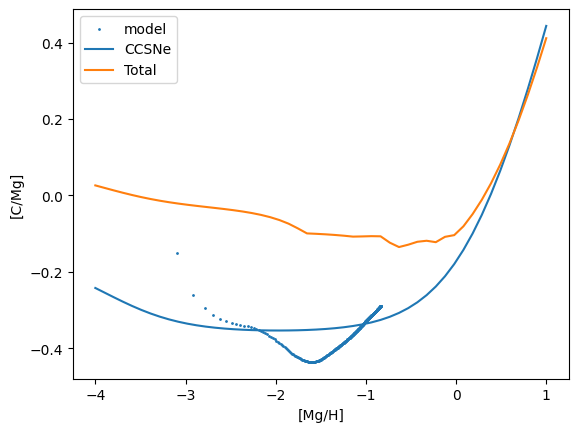

In [16]:
model = sz_model(eta=20, t_end=2, tau_star=16)


plt.scatter(model.history["[o/h]"], model.history["[c/o]"], label="model", s=1)


plt.plot(MoverH, abundance_to_bracket(y_cc_c(Z)/yo, "c", "o"), label="CCSNe")
plt.plot(MoverH, abundance_to_bracket(y_total/yo, "c", "o"), label="Total")



plt.xlabel("[Mg/H]")
plt.ylabel("[C/Mg]")

plt.legend()

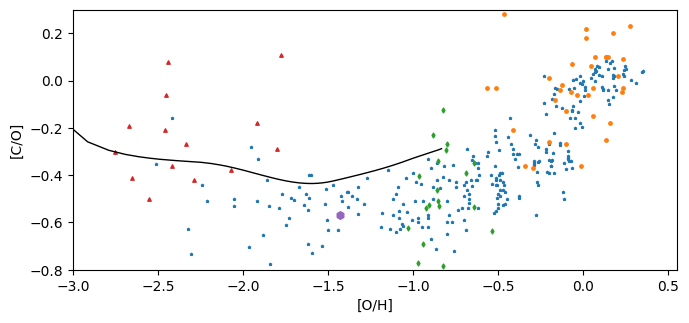

In [17]:
plt.figure(figsize=(7, 10/3))

for i in [2,0,1,3]:
    label = ["HII regions", "dwarf galaxies", "halo/thick disk stars", "damped Lyman-$\\alpha$"][i]
    val = ["RL", "dwarf", "star", "DLA"][i]
    df = all_abundances[all_abundances.type == val]
    plt.scatter(df["[o/h]"], df["[c/o]"], label=label,
               marker=["o", "d", "*", "^"][i], s=[6, 6, 3, 6][i], 
               )
    
    



# ha = subgiants["high_alpha"]
# df = subgiants[ha]
# arya.binnedplot(df, x="O_H", y="C_O", errorbar=None, binrange=(-0.3, 0.2), bins=10, stat="median", 
#                 edgecolor=arya.style.COLORS[2], facecolor='none', marker="o", s=30,
#             zorder=-1, label="subgiants, high $\\alpha$")

plt.plot()

plt.ylim(-0.8, 0.3)
plt.xlim(-3, 0.55)

plt.xlabel(r"[$\alpha$/H]")
plt.ylabel(r"[C/$\alpha$]")

plt.scatter([-1.43], [-0.57], marker="h", s=30, label="JWST ($z=7$)")


# fiducial.plot_gas("[o/h]", "[c/o]", label="Model ($t=13.2$ Gyr)", plot_data=False, zorder=3, lw=1.5, color=arya.style.COLORS[5])

# fiducial.plot_annulus_at_t("[o/h]", "[c/o]", t=2, label="Model ($t=2$ Gyr)", zorder=3, lw=2, color=arya.style.COLORS[4])


plt.plot(model.history["[o/h]"], model.history["[c/o]"], label="singlezone", color="k", lw=1, zorder=4)



# leg = arya.Legend(loc=-1).mpl_leg
#leg.legend_handles[-1].set_sizes([4])
#leg.legend_handles[-1].set_alpha(1)

plt.xlabel(r"[O/H]")
plt.ylabel(r"[C/O]")
plt.tight_layout()
